# Recurrent Neural Networks for text sentiment classification

In this notebook, we will use the Twitter dataset for sentiment classificatoin using Bi-LSTM. Given a sentence, we are going to classify whether this sentence has negative meaning. Negative meaning will have label == 0, otherwise will have label == 1.

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

import w2v
from utils import *
from preprocess import Preprocess
from model import buildModel, testing, BiLstmTuner

AUTOTUNE = tf.data.experimental.AUTOTUNE

%load_ext autoreload
%autoreload 2

In [2]:
path_prefix = Path.cwd()
print(path_prefix)

/home/meng-hao/wkspaces/Machine_Learning/repos/text_sentiment_classification


In [3]:
data_path = path_prefix.joinpath('data/')
model_path = path_prefix.joinpath('model/')
data_path.mkdir(exist_ok = True)
model_path.mkdir(exist_ok = True)

## Download Dataset
[Dataset](https://www.kaggle.com/c/ml2020spring-hw4)

There are three .txt files -- training_label.txt、training_nolabel.txt、testing_data.txt

- training_label.txt: training data with labels（0 or 1)
    - +++$+++ is separating symbols
    - e.g., 1 +++$+++ are wtf ... awww thanks !

- training_nolabel.txt：training data without labels
    - We will use this training data for semi-supervised learning
    - ex: hates being this burnt !! ouch

- testing_data.txt： Predict with testing data 

    >id,text

    >0,my dog ate our dinner . no , seriously ... he ate it .

    >1,omg last day sooon n of primary noooooo x im gona be swimming out of school wif the amount of tears am gona cry

    >2,stupid boys .. they ' re so .. stupid !

### Download dataset if not have any

In [4]:
%cd $data_path

if not os.path.exists('training_label.txt') or\
    not os.path.exists('training_nolabel.txt') or\
    not os.path.exists('testing_data.txt'):
    print("Dataset is incompleted . Downloading")
    # Method1
    !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1dPHIl8ZnfDz_fxNd2ZeBYedTat2lfxcO' -O 'training_label.txt'
    !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1x1rJOX_ETqnOZjdMAbEE2pqIjRNa8xcc' -O 'training_nolabel.txt'
    !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=16CtnQwSDCob9xmm6EdHHR7PNFNiOrQ30' -O 'testing_data.txt'

    # Method2
    # !gdown --id '1lz0Wtwxsh5YCPdqQ3E3l_nbfJT1N13V8' --output data.zip
    # !unzip data.zip
    # !ls
else:
    print("data is all set")
   
%cd $path_prefix

/home/meng-hao/wkspaces/Machine_Learning/repos/text_sentiment_classification/data
data is all set
/home/meng-hao/wkspaces/Machine_Learning/repos/text_sentiment_classification


In [5]:
# this is for filtering the warnings
import warnings
warnings.filterwarnings('ignore')

## Train Word2Vec Model

In [6]:
w2v_path = path_prefix.joinpath('model/w2v_all.model') 

if not w2v_path.exists():
    print("Train Word2Vec model via gensim")
    data_folder_path = './data'
    model_folder_path = './model'

    w2v.main(data_folder_path, model_folder_path)
else:
    print("Pretrained Word2Vec model exists")

Pretrained Word2Vec model exists


## Preprocess dataset

### Setup paths and configurations

In [7]:
# Preset the paths to dataset
train_with_label = os.path.join(path_prefix, 'data/training_label.txt')
train_no_label = os.path.join(path_prefix, 'data/training_nolabel.txt')
testing_data = os.path.join(path_prefix, 'data/testing_data.txt')

# Configuration
sen_len = 20
batch_size = 128

### Read dataset from folder

In [8]:
# Read 'training_label.txt' and 'training_nolabel.txt'
print("loading training data ...")
X_train_label, y_train_label = load_training_data(train_with_label)
X_train, X_val, y_train, y_val = train_test_split(X_train_label, 
                                                  y_train_label, 
                                                  test_size = 0.1)

train_x_no_label = load_training_data(train_no_label)

loading training data ...


In [31]:
print(f"Total number of the training data with label: {len(X_train)}")
print(f"Total number of the training data without label: {len(train_x_no_label)}")
print(f"Total number of the validation data: {len(X_val)}")

print(f"Positive rate in training dataset: {np.sum(y_train) / len(y_train)}")
print(f"Positive rate in validation dataset: {np.sum(y_val) / len(y_val)}")

Total number of the training data with label: 180000
Total number of the training data without label: 1178614
Total number of the validation data: 20000
Positive rate in training dataset: 0.5007222222222222
Positive rate in validation dataset: 0.49575


### Build the preprocessor

In [10]:
# Preprocess the training data
preprocessor = Preprocess(sen_len, w2v_path = str(w2v_path))
embedding = preprocessor.make_embedding(load = True)
X_train_idx = preprocessor.sentences_word2idx(X_train)
X_val_idx = preprocessor.sentences_word2idx(X_val)

Get embedding ...
loading word to vec model ...
total words: 55779




In [11]:
print(f"Pretrained embedding matrix shape: {embedding.shape}")

Pretrained embedding matrix shape: (55779, 250)


### Preprocess training and validation datasets

In [12]:
X_train_idx_dataset = tf.data.Dataset.from_tensor_slices(X_train_idx)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((X_train_idx_dataset, y_train_dataset))

X_val_idx_dataset = tf.data.Dataset.from_tensor_slices(X_val_idx)
y_val_dataset = tf.data.Dataset.from_tensor_slices(y_val)
val_dataset = tf.data.Dataset.zip((X_val_idx_dataset, y_val_dataset))

train_dataset = train_dataset.batch(batch_size)
val_dataset   = val_dataset.batch(batch_size)

train_dataset = train_dataset.cache().prefetch(AUTOTUNE)
val_dataset   = val_dataset.cache().prefetch(AUTOTUNE)

In [13]:
for x_batch, y_batch in train_dataset.take(1):
    print(f"x_batch shape: {x_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")    

x_batch shape: (128, 20)
y_batch shape: (128,)


## Train a bidirectional LSTM model

### Method1

#### Build the model

In [14]:
train_embedding = False # fix embedding during training
hidden_dim1 = 64
hidden_dim2 = 64
dp_rate = 0.5
lr = 0.001
epochs = 5

In [15]:
model = buildModel(embedding, train_embedding, sen_len, hidden_dim1, hidden_dim2, dp_rate, lr)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 250)           13944750  
_________________________________________________________________
dropout (Dropout)            (None, 20, 250)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 128)           161280    
_________________________________________________________________
layer_normalization (LayerNo (None, 20, 128)           40        
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
layer_normalization_1 (Layer (None, 128)              

#### Train the model

In [16]:
checkpoint_filepath = os.path.join(path_prefix, 'ckpt/')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True)

In [ ]:
history = model.fit(train_dataset, 
                  validation_data=val_dataset, 
                  epochs = epochs, 
                  callbacks=[model_checkpoint_callback])

### Method2 - with Kerastuner

In [18]:
import IPython
from kerastuner.tuners import RandomSearch

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)
    
tuner = RandomSearch(
    BiLstmTuner(embedding, train_embedding, sen_len),
    objective='val_accuracy',
    max_trials = 10,
    executions_per_trial = 3,
    directory = os.path.join(path_prefix, 'tuner_dir'),
    project_name = 'tsc')

tuner.search(train_dataset,
             epochs = 5,
             validation_data = val_dataset,
             verbose = 0,
             callbacks = [ClearTrainingOutput()],)

INFO:tensorflow:Oracle triggered exit


### Load the best model

#### Method1

In [ ]:
print('\nload model ...')
best_model = tf.keras.models.load_model(checkpoint_filepath)

#### Method2

In [74]:
# Get the optimal hyperparameters
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 250)           13944750  
_________________________________________________________________
dropout (Dropout)            (None, 20, 250)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 192)           266496    
_________________________________________________________________
layer_normalization (LayerNo (None, 20, 192)           40        
_________________________________________________________________
bidirectional_1 (Bidirection (None, 384)               591360    
_________________________________________________________________
layer_normalization_1 (Layer (None, 384)              

In [67]:
best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]
hyper_parameters = ['dp', 'lstm1', 'lstm2', 'lr']

for hp in hyper_parameters:
    print(f"best {hp} = {best_hp.get(hp)}")

best dp = 0.5504156686436646
best lstm1 = 96
best lstm2 = 192
best lr = 0.0028506288262581062


## Semi-supervised Learning 
We can further train the model using the training data without label

### Semi-supervised Learning

In [39]:
threshold_semi_learning = 0.9

In [28]:
X_train_no_label_idx = preprocessor.sentences_word2idx(train_x_no_label)

In [29]:
train_no_label_dataset = tf.data.Dataset.from_tensor_slices(X_train_no_label_idx)
train_no_label_dataset = train_no_label_dataset.batch(batch_size)
train_no_label_dataset = train_no_label_dataset.cache().prefetch(AUTOTUNE)

In [ ]:
pred_train_no_label = best_model.predict(train_no_label_dataset)

In [46]:
pred_prob_train_no_label = tf.sigmoid(pred_train_no_label)

In [51]:
X_high_conf_ind = []
y_high_conf = []

for i, prob in enumerate(pred_prob_train_no_label):
    if prob > threshold_semi_learning:
        X_high_conf_ind.append(X_train_no_label_idx[i])
        y_high_conf.append(1)
    elif prob < (1 - threshold_semi_learning):
        X_high_conf_ind.append(X_train_no_label_idx[i])
        y_high_conf.append(0)
    
print(len(X_high_conf_ind))

487477


### Combine self-training data and training dataset

In [93]:
X_total_train_idx = np.vstack((X_train_idx, np.array(X_high_conf_ind)))
y_total_train = y_train + y_high_conf

X_total_train_idx_dataset = tf.data.Dataset.from_tensor_slices(X_total_train_idx)
y_total_train_dataset = tf.data.Dataset.from_tensor_slices(y_total_train)
total_train_dataset = tf.data.Dataset.zip((X_total_train_idx_dataset, y_total_train_dataset))

total_train_dataset = total_train_dataset.batch(batch_size)
total_train_dataset = total_train_dataset.cache().prefetch(AUTOTUNE)

### Train the model again

In [96]:
best_dp = 0.5504156686436646
best_lstm1 = 96
best_lstm2 = 192
best_lr = 0.0028506288262581062

full_train_model = buildModel(embedding, train_embedding, sen_len, best_lstm1, best_lstm2, best_dp, best_lr)

full_train_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 20, 250)           13944750  
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 250)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 20, 192)           266496    
_________________________________________________________________
layer_normalization_6 (Layer (None, 20, 192)           40        
_________________________________________________________________
bidirectional_7 (Bidirection (None, 384)               591360    
_________________________________________________________________
layer_normalization_7 (Layer (None, 384)              

In [97]:
history = full_train_model.fit(total_train_dataset, 
                               epochs = 10,
                               verbose = 0)

In [98]:
metrics = full_train_model.metrics_names
results = full_train_model.evaluate(val_dataset)

for key, val in zip(metrics, results):
    print(f"{key} = {val}")

157/157 [==============================] - ETA: 0s - loss: 1.2303 - accuracy: 0.80 - ETA: 3s - loss: 1.2750 - accuracy: 0.79 - ETA: 4s - loss: 1.2813 - accuracy: 0.78 - ETA: 4s - loss: 1.2508 - accuracy: 0.78 - ETA: 4s - loss: 1.2010 - accuracy: 0.79 - ETA: 4s - loss: 1.1838 - accuracy: 0.79 - ETA: 4s - loss: 1.2008 - accuracy: 0.79 - ETA: 4s - loss: 1.2205 - accuracy: 0.78 - ETA: 4s - loss: 1.2090 - accuracy: 0.78 - ETA: 4s - loss: 1.2469 - accuracy: 0.77 - ETA: 4s - loss: 1.2434 - accuracy: 0.77 - ETA: 4s - loss: 1.2518 - accuracy: 0.77 - ETA: 4s - loss: 1.2337 - accuracy: 0.77 - ETA: 4s - loss: 1.2074 - accuracy: 0.78 - ETA: 4s - loss: 1.2215 - accuracy: 0.77 - ETA: 4s - loss: 1.2118 - accuracy: 0.77 - ETA: 4s - loss: 1.2080 - accuracy: 0.78 - ETA: 4s - loss: 1.2077 - accuracy: 0.78 - ETA: 4s - loss: 1.1992 - accuracy: 0.78 - ETA: 4s - loss: 1.2072 - accuracy: 0.78 - ETA: 4s - loss: 1.2199 - accuracy: 0.77 - ETA: 4s - loss: 1.2350 - accuracy: 0.77 - ETA: 4s - loss: 1.2271 - accuracy

In [99]:
best_model = full_train_model

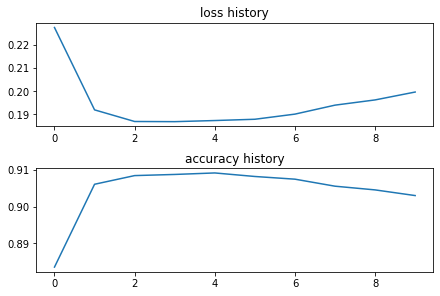

In [110]:
loss_history = history.history['loss']
acc_history = history.history['accuracy']

fig, ax = plt.subplots(2, 1, constrained_layout=True)

ax[0].plot(loss_history)
ax[0].set_title('loss history')
ax[1].plot(acc_history)
ax[1].set_title('accuracy history')

plt.show()

## Testing

### Preprocess test dataset

In [19]:
print("loading testing data ...")
X_test = load_testing_data(testing_data)
X_test_idx = preprocessor.sentences_word2idx(X_test)

loading testing data ...



In [20]:
test_dataset = tf.data.Dataset.from_tensor_slices(X_test_idx)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.cache().prefetch(AUTOTUNE)

### Make prediction

In [100]:
outputs = testing(best_model, test_dataset)

In [101]:
# Write the result to a CSV file
tmp = pd.DataFrame({"id":[str(i) for i in range(len(X_test))],"label":outputs})
print("save csv ...")
tmp.to_csv(os.path.join(path_prefix, 'predict.csv'), index=False)
print("Finish Predicting")

save csv ...
Finish Predicting
